### Notebook that reads the output of FMDeg from TCGA dataset and visualize the scatter plot of the output

### Read data 

In [2]:
import pandas as pd
import numpy as np
import os
import re
import glob
import json
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
import statsmodels.stats.multitest as mt

### paths

In [3]:
base_output = "../../../data/output_methods_selection/"
output_path = os.path.join(base_output,"output_smdeg_degrons_paper_tcga_denovo_penta")
base="../../../" 
# Path degrons
path_regions = os.path.join(base,"data","coordinates_denovodegrons.tsv.gz")
path_all_degrons = os.path.join(base,"data","de_novo_degrons.tsv")
# Path mutations CCDS
path_output_missense_degrons = os.path.join(base,"data","missense_clean_type.tsv.gz")
# Outputs
path_output_all = os.path.join(base,"data","smdeg_degrons_denovo_tcga_penta.tsv")
# Role data
role_data = os.path.join(base,"external","gene_MoA.tsv")
# Plots 
path_output_plots = os.path.join(base,"plots","Figure5")

# Aux functions

In [4]:
def load_deg(regex,globf):
    p = re.compile(regex)#"/workspace/users/fmartinez/annotation_ubiquitins/output_fml_ttype_paper/mutations_input_([A-Z]+)-oncodrivefml.tsv"
    l = []
    for filef in glob.glob(globf):#"/workspace/users/fmartinez/annotation_ubiquitins/output_fml_ttype_paper/mutations_input_*-oncodrivefml.tsv"
        
        ttype = re.search(p,filef).group(1)

        df = pd.read_csv(filef,sep="\t")

        df["Cancer_Type"] = ttype
        
        df.rename(columns={"ENSEMBLT":"Hugo_Symbol","REGION":"GENE_ID"},inplace=True)
        
        if df.shape[0] >0:
            #print (filef)
            df=df[(np.isfinite(df["P_VALUE"]))&(df["MEAN_SIMULATED"]>0)&(df["OBSERVED_REGION"]>2)] # not an error
            if df.shape[0] > 0:
                df["DEGRON"] = df.apply(lambda row: row["GENE_ID"].split(":")[1],axis=1)
                df["Entry_Isoform"] = df.apply(lambda row: row["GENE_ID"].split(":")[0],axis=1)
                df["STARTF"] = df.apply(lambda row: int(row["GENE_ID"].split(":")[2]),axis=1)
                df["STOPF"] = df.apply(lambda row: int(row["GENE_ID"].split(":")[3]),axis=1)
                l.append(df)
    df_total = pd.concat(l)
    return df_total

def match_df_degrons(df_output):
   
    df_regions_info = pd.read_csv(path_regions,sep="\t",compression="gzip")
    df_degrons = pd.read_csv(path_all_degrons,sep="\t")
    df_regions_info.START_FLANKING = df_regions_info.START_FLANKING.astype(int)
    df_regions_info.END_FLANKING = df_regions_info.END_FLANKING.astype(int)
    df_regions_info.START = df_regions_info.START.astype(int)
    df_regions_info.END = df_regions_info.END.astype(int)
    df_fml = pd.merge(left=df_regions_info[["Entry_Isoform","START_FLANKING","END_FLANKING","START","END"]],right=df_output,left_on=["Entry_Isoform","START_FLANKING","END_FLANKING"],right_on=["Entry_Isoform","STARTF","STOPF"])
    
    # Only retain the CCDS of mutatiions from TCGA
    df_data = pd.read_csv(path_output_missense_degrons,sep="\t",compression="gzip")
    df_fml_degron = pd.merge(df_fml,df_data[["CCDS","Entry_Isoform"]].drop_duplicates())
    return df_fml_degron
def get_smdeg():
    df = load_deg(output_path+"/([A-Z]+)-smdeg.tsv",output_path+"/*-smdeg.tsv")
    return match_df_degrons(df)
def get_odd_ratio(row):
    a = (row["OBSERVED_REGION"])
    b =  (row["TOTAL_MUTS_GENE"] - row["OBSERVED_REGION"]) 
    c =  (row["MEAN_SIMULATED"] )
    d =  (row["TOTAL_MUTS_GENE"] - row["MEAN_SIMULATED"])
    if (b==0):
        return a
    elif (c==0) or (d==0):
        return np.nan
    return (a/b) / (c/d)
def set_color(row,colors):
    if row["Cancer_Type"] in colors:
        return colors[row["Cancer_Type"]]
    else:
        return "black"

# Read SMDeg

### We defined as significant:
-- Tumor types:  effect_size > 1 and Q_VALUE <0.1



In [5]:
df_sm_degron_ttype = get_smdeg()
df_sm_degron_ttype["P_VALUE_SIM_TCGA"] = df_sm_degron_ttype.apply(lambda row: float("{0:.2E}".format((row["P_VALUE"]))),axis=1)
df_sm_degron_ttype["Q_VALUE_SIM_TCGA"] = df_sm_degron_ttype.apply(lambda row: float("{0:.2E}".format((row["Q_VALUE"]))),axis=1)
df_sm_degron_ttype["ODD_RATIO"] = df_sm_degron_ttype.apply(lambda row: get_odd_ratio(row),axis=1) 
df_sm_degron_ttype["log2(ODD_RATIO)"] = 1+np.log2(df_sm_degron_ttype["ODD_RATIO"])
df_sm_degron_ttype["effect_size_sm"] = df_sm_degron_ttype.apply(lambda row: float("{0:.2E}".format((np.log2((row["OBSERVED_REGION"]/row["MEAN_SIMULATED"])+1)))) if row["MEAN_SIMULATED"] > 0 else np.nan ,axis=1)
df_sm_degron_ttype["log_pvalue_sm"] = df_sm_degron_ttype.apply(lambda row: -np.log10(row["P_VALUE_SIM_TCGA"]),axis=1)
df_sm_degron_ttype["log_qvalue_sm"] = df_sm_degron_ttype.apply(lambda row: -np.log10(row["Q_VALUE_SIM_TCGA"]),axis=1)
df_sm_degron_ttype.drop(columns=["P_VALUE","Q_VALUE","ODD_RATIO"],inplace=True)
df_sm_degron_ttype["significant_SM"] = df_sm_degron_ttype.apply(lambda row: True if row["effect_size_sm"]>1  and row["OBSERVED_REGION"]>2 and row["Q_VALUE_SIM_TCGA"] < 0.01  else  False,axis=1)

### Save two dataframes one for all significant other significant + PPI

In [6]:
df_sm_degron_ttype.rename(columns={"OBSERVED_REGION":"n_missense_TCGA_denovo"},inplace=True)
df_sm_degron_ttype[["HUGO_SYMBOL","Entry_Isoform","DEGRON","START","END","effect_size_sm","log_pvalue_sm","Cancer_Type","P_VALUE_SIM_TCGA","significant_SM","Q_VALUE_SIM_TCGA","n_missense_TCGA_denovo"]].to_csv(path_output_all,sep="\t",index=False)



### define colors

In [7]:
dict_colors = json.load(open("dict_colors.json",'r'))


# Plot FM

### Prepare plots

In [8]:
df_sm_degron_ttype["color"] = df_sm_degron_ttype.apply(lambda row:set_color(row,dict_colors),axis=1)
df_sm_degron_ttype["text"] = df_sm_degron_ttype.apply(lambda row:row["HUGO_SYMBOL"]+":"+str(row["START"])+":"+str(row["END"]),axis=1)

### Matplotlib

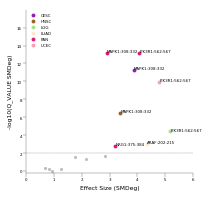

In [11]:
fig,ax = plt.subplots(figsize=(3,3))
df_sigs = df_sm_degron_ttype[(df_sm_degron_ttype["significant_SM"])]
df_not_sigs = df_sm_degron_ttype[~(df_sm_degron_ttype["significant_SM"])]
for cancer_type in df_sigs["Cancer_Type"].unique():
    ys = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["log_qvalue_sm"].values
    xs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["effect_size_sm"].values
    sc=ax.scatter(x=xs,y=ys,color=dict_colors[cancer_type],s=15,linewidths=0,label=cancer_type,marker="o")
    for i in range(len(xs)):
        
        ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        pass

ax.scatter(x=df_not_sigs["effect_size_sm"].values,y=df_not_sigs["log_qvalue_sm"].values,color="grey",s=10,alpha=0.5,linewidths=0)
#Set legend
marker_size = 15
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
    handle.set_linewidth(0)
ax.legend(handler_map={type(sc): HandlerPathCollection(update_func=update_prop)},scatterpoints=1, frameon=False, labelspacing=0.5, markerscale=1,loc="upper left",fontsize=4,labels=labels,handles=handles)
# Adjust axis
ax.set_ylabel("-log10(Q_VALUE SMDeg)",fontsize=6)
ax.set_xlabel("Effect Size (SMDeg)",fontsize=6)
limit = 16
ylim = (-0.2,limit+2)
ax.set_ylim(ylim)
ax.set_yticks([x for x in range(int(ylim[0]),ylim[1]-1,2)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
ax.axhline(y=-np.log10(0.01),xmin=0,xmax=np.nanmax(df_sigs["log_qvalue_sm"].values),color="black",ls="--",lw=0.2)
# x-axis
xlim = (0,6)
ax.set_xlim(xlim)
ax.set_xticks([x for x in range(xlim[0],xlim[1]+1,1)])


#x=ax.legend()
plt.savefig(path_output_plots+'/SM_denovo_tcga_penta.pdf', dpi=100,bbox_inches="tight")
None